<a href="https://colab.research.google.com/github/Siphephelo-dev/DataScienceProject/blob/main/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import time
import os
from google.colab import files
import zipfile
import urllib.request

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")


✓ All libraries imported successfully!
TensorFlow version: 2.19.0
GPU available: False


In [2]:
def download_movielens_data():
    """Download MovieLens 100K dataset"""
    url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
    zip_path = "ml-100k.zip"

    if not os.path.exists('ml-100k'):
        print("Downloading MovieLens 100K dataset...")
        urllib.request.urlretrieve(url, zip_path)

        print("Extracting files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall()

        os.remove(zip_path)
        print("✓ Dataset downloaded and extracted successfully!")
    else:
        print("✓ Dataset already exists!")

    return 'ml-100k/u.data', 'ml-100k/u.item'

# Download data
ratings_path, movies_path = download_movielens_data()

Extracting files...
✓ Dataset downloaded and extracted successfully!


In [3]:
class DataLoader:
    """Load and preprocess MovieLens dataset"""

    def __init__(self, ratings_path='ml-100k/u.data', movies_path='ml-100k/u.item'):
        self.ratings_path = ratings_path
        self.movies_path = movies_path

    def load_data(self):
        """Load ratings and movie data"""
        # Load ratings
        ratings = pd.read_csv(
            self.ratings_path,
            sep='\t',
            names=['user_id', 'movie_id', 'rating', 'timestamp']
        )

        # Load movies
        movies = pd.read_csv(
            self.movies_path,
            sep='|',
            encoding='latin-1',
            names=['movie_id', 'title', 'release_date', 'video_release_date',
                   'imdb_url'] + [f'genre_{i}' for i in range(19)],
            usecols=[0, 1]  # Only load movie_id and title
        )

        return ratings, movies

    def preprocess(self, ratings):
        """Clean and prepare data"""
        # Remove timestamp
        ratings = ratings.drop('timestamp', axis=1)

        # Create user and movie mappings
        user_ids = ratings['user_id'].unique()
        movie_ids = ratings['movie_id'].unique()

        user_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}
        movie_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}
        idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}

        ratings['user_idx'] = ratings['user_id'].map(user_to_idx)
        ratings['movie_idx'] = ratings['movie_id'].map(movie_to_idx)

        return ratings, user_to_idx, movie_to_idx, idx_to_movie

# Load and preprocess data
print("Loading and preprocessing data...")
loader = DataLoader(ratings_path, movies_path)
ratings, movies = loader.load_data()
ratings, user_to_idx, movie_to_idx, idx_to_movie = loader.preprocess(ratings)

n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

print(f"\n✓ Dataset loaded successfully!")
print(f"  • Total ratings: {len(ratings):,}")
print(f"  • Unique users: {n_users:,}")
print(f"  • Unique movies: {n_movies:,}")
print(f"  • Sparsity: {(1 - len(ratings)/(n_users*n_movies))*100:.2f}%")

# Display sample data
print("\nSample ratings:")
display(ratings.head(10))


Loading and preprocessing data...

✓ Dataset loaded successfully!
  • Total ratings: 100,000
  • Unique users: 943
  • Unique movies: 1,682
  • Sparsity: 93.70%

Sample ratings:


,user_id,movie_id,rating,user_idx,movie_idx
0,196,242,3,0,0
1,186,302,3,1,1
2,22,377,1,2,2
3,244,51,2,3,3
4,166,346,1,4,4
5,298,474,4,5,5
6,115,265,2,6,6
7,253,465,5,7,7
8,305,451,3,8,8
9,6,86,3,9,9


from matplotlib import pyplot as plt
_df_0['user_id'].plot(kind='hist', bins=20, title='user_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['movie_id'].plot(kind='hist', bins=20, title='movie_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['user_idx'].plot(kind='hist', bins=20, title='user_idx')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='user_id', y='movie_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='movie_id', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='rating', y='user_idx', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='user_idx', y='movie_idx', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_idx']
  ys = series['user_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('user_idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_idx')
_ = plt.ylabel('user_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_idx']
  ys = series['movie_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('user_idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_idx')
_ = plt.ylabel('movie_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user_idx']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('user_idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_idx')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user_idx']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user_idx'}, axis=1)
              .sort_values('user_idx', ascending=True))
  xs = counted['user_idx']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('user_idx', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user_idx')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['user_id'].plot(kind='line', figsize=(8, 4), title='user_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['movie_id'].plot(kind='line', figsize=(8, 4), title='movie_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['user_idx'].plot(kind='line', figsize=(8, 4), title='user_idx')
plt.gca().spines[['top', 'right']].set_visible(False)

EXPLORATORY DATA ANALYSIS

Dataset Statistics:
  • Total ratings: 100,000
  • Unique users: 943
  • Unique movies: 1,682
  • Rating range: 1 - 5
  • Average rating: 3.53
  • Median rating: 4.0
  • Standard deviation: 1.13
  • Matrix sparsity: 93.70%

User Statistics:
  • Min ratings per user: 20
  • Max ratings per user: 737
  • Avg ratings per user: 106.0

Movie Statistics:
  • Min ratings per movie: 1
  • Max ratings per movie: 583
  • Avg ratings per movie: 59.5

✓ EDA visualizations saved as 'eda_analysis.png'


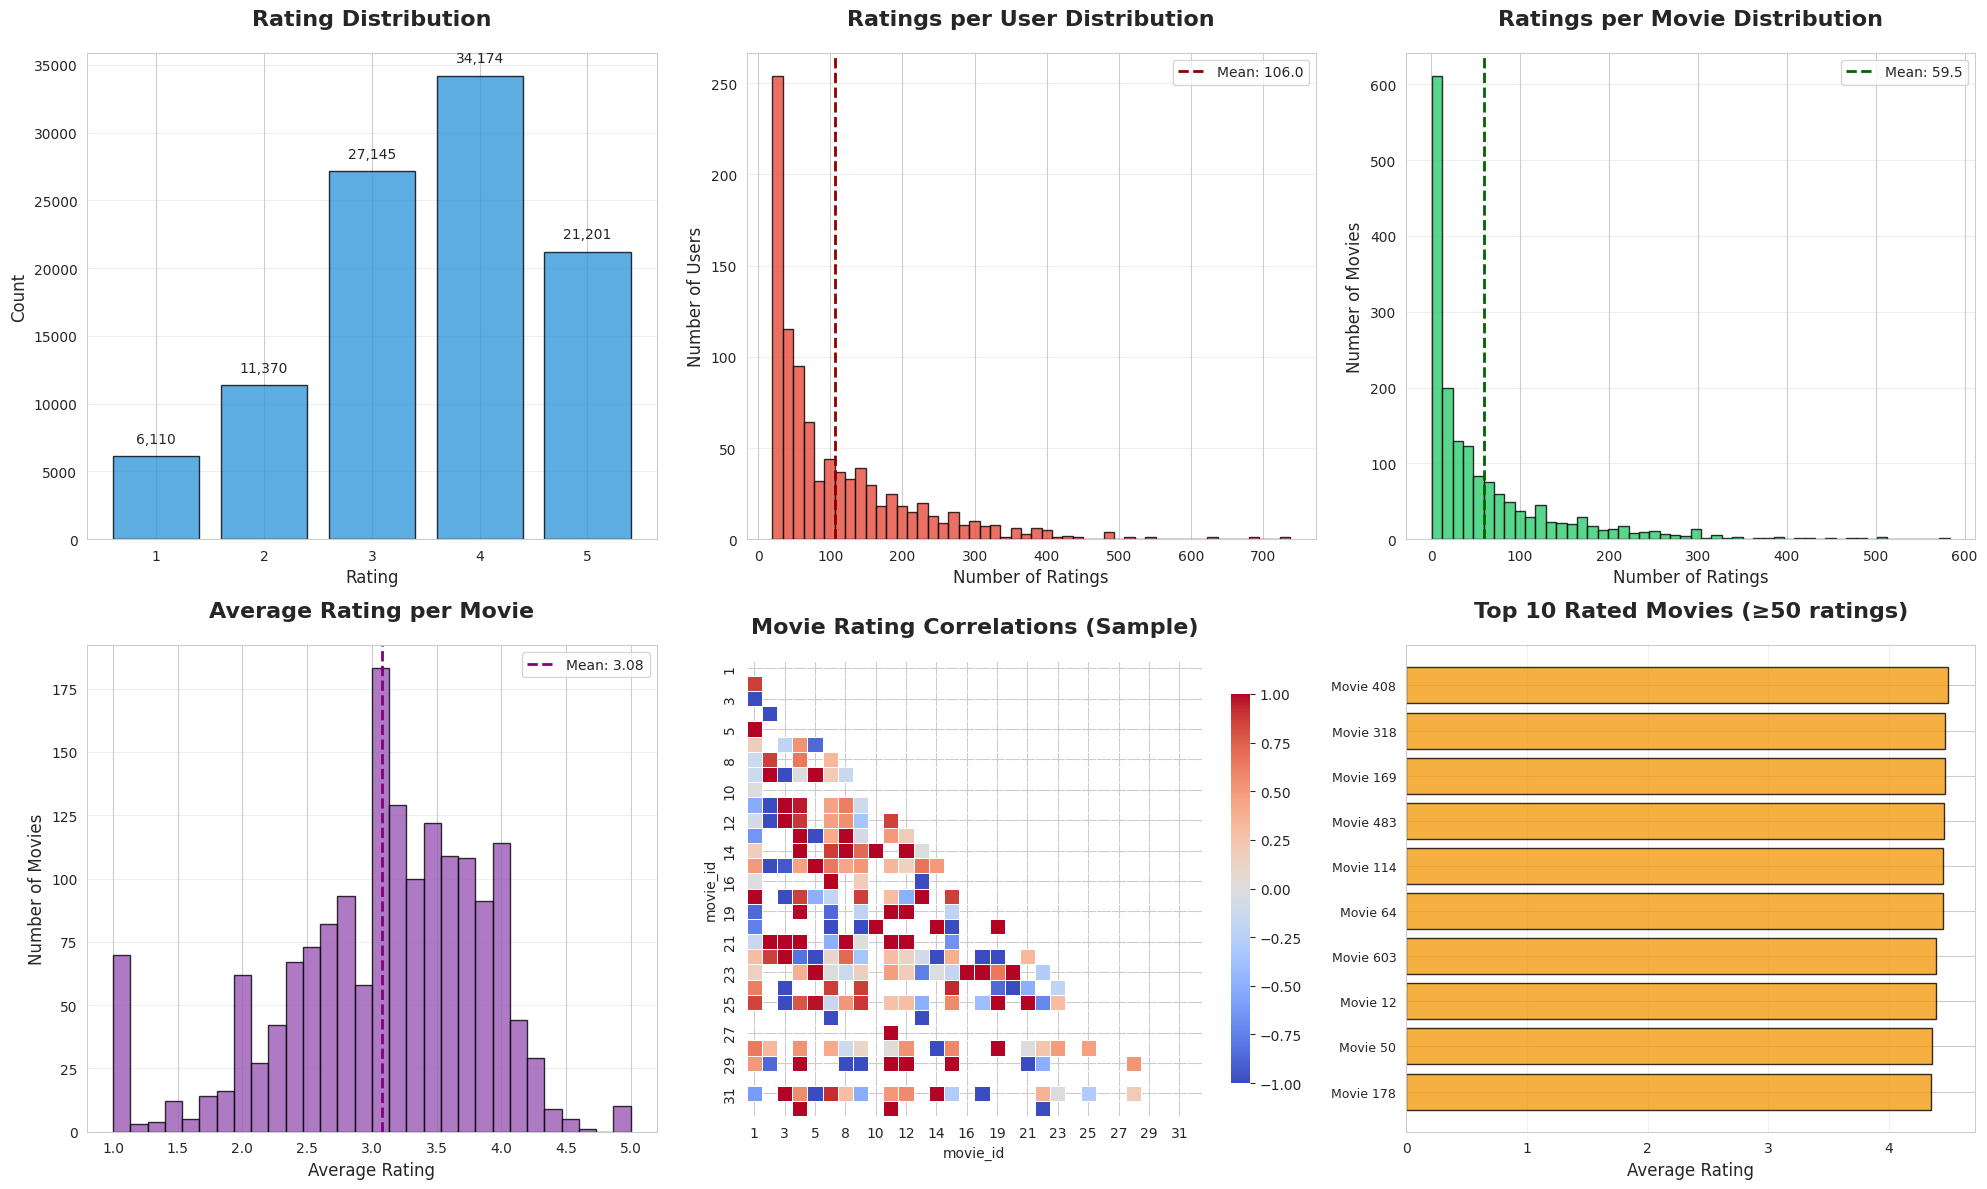

In [4]:
def exploratory_data_analysis(ratings, movies):
    """Perform EDA and create visualizations"""
    print("=" * 70)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 70)

    # Basic statistics
    print(f"\nDataset Statistics:")
    print(f"  • Total ratings: {len(ratings):,}")
    print(f"  • Unique users: {ratings['user_id'].nunique():,}")
    print(f"  • Unique movies: {ratings['movie_id'].nunique():,}")
    print(f"  • Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
    print(f"  • Average rating: {ratings['rating'].mean():.2f}")
    print(f"  • Median rating: {ratings['rating'].median():.1f}")
    print(f"  • Standard deviation: {ratings['rating'].std():.2f}")

    # Calculate sparsity
    sparsity = (1 - len(ratings) / (ratings['user_id'].nunique() *
                                     ratings['movie_id'].nunique())) * 100
    print(f"  • Matrix sparsity: {sparsity:.2f}%")

    # User statistics
    ratings_per_user = ratings.groupby('user_id').size()
    print(f"\nUser Statistics:")
    print(f"  • Min ratings per user: {ratings_per_user.min()}")
    print(f"  • Max ratings per user: {ratings_per_user.max()}")
    print(f"  • Avg ratings per user: {ratings_per_user.mean():.1f}")

    # Movie statistics
    ratings_per_movie = ratings.groupby('movie_id').size()
    print(f"\nMovie Statistics:")
    print(f"  • Min ratings per movie: {ratings_per_movie.min()}")
    print(f"  • Max ratings per movie: {ratings_per_movie.max()}")
    print(f"  • Avg ratings per movie: {ratings_per_movie.mean():.1f}")

    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Rating distribution
    rating_dist = ratings['rating'].value_counts().sort_index()
    axes[0, 0].bar(rating_dist.index, rating_dist.values, color='#3498db', edgecolor='black', alpha=0.8)
    axes[0, 0].set_title('Rating Distribution', fontsize=16, fontweight='bold', pad=20)
    axes[0, 0].set_xlabel('Rating', fontsize=12)
    axes[0, 0].set_ylabel('Count', fontsize=12)
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(rating_dist.values):
        axes[0, 0].text(rating_dist.index[i], v + 1000, f'{v:,}', ha='center', fontsize=10)

    # 2. Ratings per user
    axes[0, 1].hist(ratings_per_user, bins=50, color='#e74c3c', edgecolor='black', alpha=0.8)
    axes[0, 1].set_title('Ratings per User Distribution', fontsize=16, fontweight='bold', pad=20)
    axes[0, 1].set_xlabel('Number of Ratings', fontsize=12)
    axes[0, 1].set_ylabel('Number of Users', fontsize=12)
    axes[0, 1].axvline(ratings_per_user.mean(), color='darkred', linestyle='--',
                       linewidth=2, label=f'Mean: {ratings_per_user.mean():.1f}')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)

    # 3. Ratings per movie
    axes[0, 2].hist(ratings_per_movie, bins=50, color='#2ecc71', edgecolor='black', alpha=0.8)
    axes[0, 2].set_title('Ratings per Movie Distribution', fontsize=16, fontweight='bold', pad=20)
    axes[0, 2].set_xlabel('Number of Ratings', fontsize=12)
    axes[0, 2].set_ylabel('Number of Movies', fontsize=12)
    axes[0, 2].axvline(ratings_per_movie.mean(), color='darkgreen', linestyle='--',
                       linewidth=2, label=f'Mean: {ratings_per_movie.mean():.1f}')
    axes[0, 2].legend()
    axes[0, 2].grid(axis='y', alpha=0.3)

    # 4. Average rating per movie
    avg_ratings = ratings.groupby('movie_id')['rating'].mean()
    axes[1, 0].hist(avg_ratings, bins=30, color='#9b59b6', edgecolor='black', alpha=0.8)
    axes[1, 0].set_title('Average Rating per Movie', fontsize=16, fontweight='bold', pad=20)
    axes[1, 0].set_xlabel('Average Rating', fontsize=12)
    axes[1, 0].set_ylabel('Number of Movies', fontsize=12)
    axes[1, 0].axvline(avg_ratings.mean(), color='purple', linestyle='--',
                       linewidth=2, label=f'Mean: {avg_ratings.mean():.2f}')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 5. Rating correlation heatmap (sample)
    sample_users = np.random.choice(ratings['user_id'].unique(), min(50, n_users), replace=False)
    sample_data = ratings[ratings['user_id'].isin(sample_users)]
    pivot = sample_data.pivot_table(index='user_id', columns='movie_id', values='rating')

    # Calculate correlation
    corr = pivot.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr.iloc[:30, :30], mask=mask[:30, :30], cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[1, 1])
    axes[1, 1].set_title('Movie Rating Correlations (Sample)', fontsize=16, fontweight='bold', pad=20)

    # 6. Top rated movies
    movie_stats = ratings.groupby('movie_id').agg({
        'rating': ['mean', 'count']
    }).reset_index()
    movie_stats.columns = ['movie_id', 'avg_rating', 'count']
    movie_stats = movie_stats[movie_stats['count'] >= 50]  # Filter movies with at least 50 ratings
    top_movies = movie_stats.nlargest(10, 'avg_rating')

    axes[1, 2].barh(range(len(top_movies)), top_movies['avg_rating'], color='#f39c12',
                    edgecolor='black', alpha=0.8)
    axes[1, 2].set_yticks(range(len(top_movies)))
    axes[1, 2].set_yticklabels([f"Movie {mid}" for mid in top_movies['movie_id']], fontsize=9)
    axes[1, 2].set_xlabel('Average Rating', fontsize=12)
    axes[1, 2].set_title('Top 10 Rated Movies (≥50 ratings)', fontsize=16, fontweight='bold', pad=20)
    axes[1, 2].grid(axis='x', alpha=0.3)
    axes[1, 2].invert_yaxis()

    plt.tight_layout()
    plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✓ EDA visualizations saved as 'eda_analysis.png'")
    plt.show()

# Perform EDA
exploratory_data_analysis(ratings, movies)



In [5]:
class CollaborativeFiltering:
    """Traditional User-Based Collaborative Filtering"""

    def __init__(self, n_neighbors=50):
        self.n_neighbors = n_neighbors
        self.user_similarity = None
        self.train_matrix = None

    def fit(self, train_data, n_users, n_movies):
        """Train collaborative filtering model"""
        print("Building user-item matrix...")
        self.train_matrix = np.zeros((n_users, n_movies))
        for _, row in train_data.iterrows():
            self.train_matrix[int(row['user_idx']), int(row['movie_idx'])] = row['rating']

        print("Calculating user similarity matrix...")
        self.user_similarity = cosine_similarity(self.train_matrix)
        print("✓ CF model training complete!")

    def predict(self, user_idx, movie_idx):
        """Predict rating for user-movie pair"""
        if self.train_matrix[user_idx, movie_idx] > 0:
            return self.train_matrix[user_idx, movie_idx]

        similar_users = self.user_similarity[user_idx]
        rated_users = self.train_matrix[:, movie_idx] > 0

        if not any(rated_users):
            user_ratings = self.train_matrix[user_idx][self.train_matrix[user_idx] > 0]
            return np.mean(user_ratings) if len(user_ratings) > 0 else 3.0

        similar_rated = similar_users * rated_users
        top_users = np.argsort(similar_rated)[-self.n_neighbors:]

        numerator = np.sum(similar_rated[top_users] * self.train_matrix[top_users, movie_idx])
        denominator = np.sum(np.abs(similar_rated[top_users])) + 1e-8

        prediction = numerator / denominator

        if prediction == 0:
            user_ratings = self.train_matrix[user_idx][self.train_matrix[user_idx] > 0]
            prediction = np.mean(user_ratings) if len(user_ratings) > 0 else 3.0

        return np.clip(prediction, 1, 5)

print("Collaborative Filtering model class defined!")


# ============================================================================
# CELL 6: Neural Collaborative Filtering Model
# ============================================================================

class NeuralCollaborativeFiltering:
    """Deep Neural Network for Collaborative Filtering"""

    def __init__(self, n_users, n_movies, embedding_dim=50):
        self.n_users = n_users
        self.n_movies = n_movies
        self.embedding_dim = embedding_dim
        self.model = self._build_model()

    def _build_model(self):
        """Build neural network architecture"""
        # User input and embedding
        user_input = layers.Input(shape=(1,), name='user_input')
        user_embedding = layers.Embedding(
            self.n_users,
            self.embedding_dim,
            name='user_embedding',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )(user_input)
        user_flat = layers.Flatten()(user_embedding)

        # Movie input and embedding
        movie_input = layers.Input(shape=(1,), name='movie_input')
        movie_embedding = layers.Embedding(
            self.n_movies,
            self.embedding_dim,
            name='movie_embedding',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )(movie_input)
        movie_flat = layers.Flatten()(movie_embedding)

        # Concatenate embeddings
        concat = layers.Concatenate()([user_flat, movie_flat])

        # Deep layers with batch normalization
        dense1 = layers.Dense(128, activation='relu')(concat)
        bn1 = layers.BatchNormalization()(dense1)
        dropout1 = layers.Dropout(0.3)(bn1)

        dense2 = layers.Dense(64, activation='relu')(dropout1)
        bn2 = layers.BatchNormalization()(dense2)
        dropout2 = layers.Dropout(0.3)(bn2)

        dense3 = layers.Dense(32, activation='relu')(dropout2)

        # Output layer
        output = layers.Dense(1, activation='linear')(dense3)

        model = keras.Model(inputs=[user_input, movie_input], outputs=output)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        return model

    def fit(self, train_data, validation_data=None, epochs=20, batch_size=256):
        """Train neural network"""
        X_train_user = train_data['user_idx'].values
        X_train_movie = train_data['movie_idx'].values
        y_train = train_data['rating'].values

        if validation_data is not None:
            X_val_user = validation_data['user_idx'].values
            X_val_movie = validation_data['movie_idx'].values
            y_val = validation_data['rating'].values
            validation = ([X_val_user, X_val_movie], y_val)
        else:
            validation = None

        # Create callbacks
        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss' if validation else 'loss',
            patience=5,
            restore_best_weights=True
        )

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss' if validation else 'loss',
            factor=0.5,
            patience=3,
            min_lr=0.00001
        )

        history = self.model.fit(
            [X_train_user, X_train_movie],
            y_train,
            validation_data=validation,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )

        return history

    def predict(self, user_indices, movie_indices):
        """Predict ratings"""
        predictions = self.model.predict([user_indices, movie_indices], verbose=0)
        return np.clip(predictions.flatten(), 1, 5)

print("Neural Collaborative Filtering model class defined!")




Collaborative Filtering model class defined!
Neural Collaborative Filtering model class defined!


In [6]:
class HybridRecommender:
    """Hybrid model combining CF and Neural Network"""

    def __init__(self, cf_model, nn_model, alpha=0.5):
        self.cf_model = cf_model
        self.nn_model = nn_model
        self.alpha = alpha

    def predict(self, user_idx, movie_idx):
        """Combine predictions from both models"""
        cf_pred = self.cf_model.predict(user_idx, movie_idx)
        nn_pred = self.nn_model.predict(np.array([user_idx]), np.array([movie_idx]))[0]

        hybrid_pred = self.alpha * cf_pred + (1 - self.alpha) * nn_pred
        return np.clip(hybrid_pred, 1, 5)

print("Hybrid Recommender model class defined!")



Hybrid Recommender model class defined!


In [7]:
class ModelEvaluator:
    """Evaluate model performance"""

    @staticmethod
    def calculate_rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    @staticmethod
    def calculate_mae(y_true, y_pred):
        return mean_absolute_error(y_true, y_pred)

    @staticmethod
    def calculate_r2(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

print("Model Evaluator class defined!")


Model Evaluator class defined!


In [8]:
print("Splitting data into train and test sets (80-20 split)...")
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"✓ Training set: {len(train_data):,} ratings ({len(train_data)/len(ratings)*100:.1f}%)")
print(f"✓ Test set: {len(test_data):,} ratings ({len(test_data)/len(ratings)*100:.1f}%)")

Splitting data into train and test sets (80-20 split)...
✓ Training set: 80,000 ratings (80.0%)
✓ Test set: 20,000 ratings (20.0%)


In [9]:
print("\n" + "=" * 70)
print("TRAINING COLLABORATIVE FILTERING MODEL")
print("=" * 70)

cf_start = time.time()
cf_model = CollaborativeFiltering(n_neighbors=50)
cf_model.fit(train_data, n_users, n_movies)
cf_time = time.time() - cf_start

print(f"\n✓ CF training completed in {cf_time:.2f} seconds")




TRAINING COLLABORATIVE FILTERING MODEL
Building user-item matrix...
Calculating user similarity matrix...
✓ CF model training complete!

✓ CF training completed in 4.04 seconds



TRAINING NEURAL COLLABORATIVE FILTERING MODEL

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     47,150 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │     84,100 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 155,315 (606.70 KB)

 Trainable params: 154,931 (605.20 KB)

 Non-trainable params: 384 (1.50 KB)


Training neural network...
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.3732 - mae: 2.1368 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2964 - mae: 0.9135 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.1442 - mae: 0.8549 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0433 - mae: 0.8138 - learning_rate: 0.0010
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9986 - mae: 0.7956 - learning_rate: 0.0010
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9654 - mae: 0.7813 - learning_rate: 0.0010
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9334 - mae: 0.7682 - learning_rate: 0.0010
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9035 - mae: 0.7556 - learning_rate: 0.0010
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8834 - mae: 0.7451 - learning_rate: 0.0010
Epoch 10/20
313/313 ━━━━━

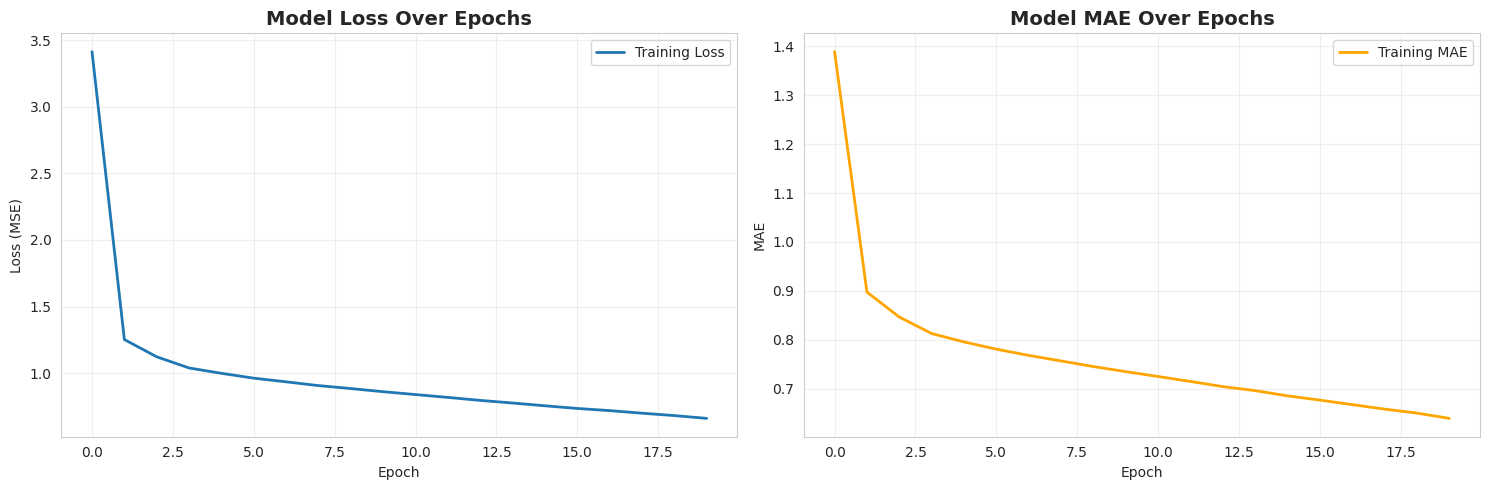

In [10]:
print("\n" + "=" * 70)
print("TRAINING NEURAL COLLABORATIVE FILTERING MODEL")
print("=" * 70)

nn_start = time.time()
nn_model = NeuralCollaborativeFiltering(n_users, n_movies, embedding_dim=50)
print("\nModel Architecture:")
nn_model.model.summary()

print("\nTraining neural network...")
history = nn_model.fit(train_data, epochs=20, batch_size=256)
nn_time = time.time() - nn_start

print(f"\n✓ Neural network training completed in {nn_time:.2f} seconds")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, color='orange')
axes[1].set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()
